## Custom written code to generate Figure 5,  Figure 6 and Figure 7 for Liu 2023

Run under the analysis environment

Figure 5. Top 75 innervated region

Figure 6. Categorical and spatial correlation between all samples

Figure 7. Innervation centers in MO regions

Note that must obtain intermediate files (xlsx and csv files) from notebook for Figure 3 and 4 as well as Figure 7_preparation

In [3]:
import os
import numpy as np
import seaborn as sns

import pandas as pd
pd.options.mode.chained_assignment = None 
# disable the chained assignment warning

import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

# use seaborn for easier logrithmic color scale

import itertools
# use itertool to flatten list of list

In [4]:
#define helpful functions

def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]


def average_excel(name_list, side, output_name):
    parent_axons= [ i for i  in os.listdir(folder) if f'{side}_region' in i]
    #change side to right for the other hemisphere!
    
    file_list=[]
    for i in name_list:
        contained = [x for x in parent_axons if i in x]
        file_list.append(contained[0])
    # extract all the file containing thesample name
    
    print('now processing the following files:')
    print(f'{file_list}')
    
    out_name=os.path.join(outdir,output_name)
    
    axonal_df= combine_df(folder, file_list)
    #axonal_df=axonal_df.T
    
    y=axonal_df.index.to_list()
    test_order=[]

    for i in y:
        name=atlas_labels.query(f"acronym== '{i}'").graph_order.values[0]
        test_order.append(name)

    sort_acronym_df= pd.DataFrame({'acronyms':y, 'graph_order': test_order})
    sort_acronym_df.sort_values('graph_order', inplace=True)
    # sort the aconnyms based on graph order

    final_df= axonal_df.reindex(sort_acronym_df.acronyms.to_list())
    #final_df
    
    final_df['average']=final_df.mean(axis=1)
    final_df['std']= final_df.std(axis=1)
    # compute average and std
    
    result = pd.merge(final_df.reset_index(), atlas_labels, on=['acronym'])
    # need to reset_index here because acronym was both an index and a column
    
    result.to_excel(f'{out_name}_avg_{side}.xlsx') 
    
    return 


def parent_df(df):
    # group dataframe by parent id structure
    grouped_pd=df.groupby(['parent_structure_id'],as_index=False).sum()
    d= {'id': grouped_pd.parent_structure_id.astype(int), 'average': grouped_pd.average}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, atlas_labels, on=["id"])
    result.sort_values(['average'], ascending=True, inplace=True)
    # result is the final pd

    return result

def clean_duplicate(df):
    '''This is needed again to account for parent regions that have its subregion incompletely covers the parent areas.
    A painful example is Zona incerta, since it has a depth of 6, after group by parents it will show up twice with different counts where we simply just add the two counts'''
    
    df2=df.groupby(['acronym'],as_index=False, sort=False).sum()
    d= {'acronym': df2.acronym, 'average': df2.average}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, atlas_labels, on=["acronym"])
    # this merging is required because pd.groupby will drop 'useless columns' such as depth, structure id path and other useful ones!! So we fetch them back here..
    # Probably have better ways of doing it...
    
    return result


def get_parent_excel(subregion_df):
    ''' quantify axon counts in broader anatomical regions
    regions with depth>6 will be grouped one level up
    '''
    

    axon_sub=subregion_df.sort_values(by=['average'])
    axon_sub.sort_values(by= 'graph_order',axis=0, inplace=True)

    needsgroup=axon_sub[axon_sub.depth>6]
    noneedsgroup=axon_sub[axon_sub.depth<=6]

    parent= parent_df(needsgroup)

    complete1=noneedsgroup.append(parent)

    complete=clean_duplicate(complete1)

    complete.sort_values('average',ascending=False, inplace=True)
    
    return complete


def prep_df(df):
    ''' now only include regions belonging to and /343/ brainstem /567/ cerebrum  (but excluding /698/ olfactory areas and /1089/ hippocampal formation that belongs under /567/)'''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    
    read_file= pd.read_excel(df)
    
    searchfor = ['/567/', '/343/']
    cc_cb= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 only
    
    search_exclude = ['/1089/', '/698/']
    cc_cb_clean= cc_cb.loc[~cc_cb['structure_id_path'].str.contains('|'.join(search_exclude), case=False)]
    # exclude regions under 698 olfactory areas and 1089 hippocampal formation
      
    new= cc_cb_clean.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def prep_df2(df, genotype_name):
    ''' now only include regions belonging to and /343/ brainstem /567/ cerebrum  (but excluding /698/ olfactory areas and /1089/ hippocampal formation that belongs under /567/)'''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    
    read_file= df
    
    searchfor = ['/567/', '/343/']
    cc_cb= read_file.loc[read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]
    # select cerebrum 567, brain stem 343 only
    
    search_exclude = ['/1089/', '/698/']
    cc_cb_clean= cc_cb.loc[~cc_cb['structure_id_path'].str.contains('|'.join(search_exclude), case=False)]
    # exclude regions under 698 olfactory areas and 1089 hippocampal formation
      
    new= cc_cb_clean.set_index('acronym').T
    new_series=new.loc['average']

    full_df= new_series.to_frame()
    full_df.rename(columns={'average': genotype_name}, inplace=1)
    return full_df

def combine_df(folder,list_of_fname):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_df=[]
    
    for i in (list_of_fname):
        new_df=prep_df(os.path.join(folder, i))
        full_df.append(new_df)

    full_df=pd.concat(full_df,axis=1)
    return full_df

In [ ]:
working_directory= r'E:\CodeTest' 
# this directory should contain folders Horizontal_Axon, ARA_25_micron_mhd_ccf2017, and file injection_sites_results_expanded.xlsx

### Figure 5

Top 75 innervated regions based on group averages

In [3]:
# generate average data from individual excel files

atlas_labels=pd.read_csv(f'{working_directory}\ARA_25_micron_mhd_ccf2017\labels.csv')
#load atlas labels


In [4]:
region='s2'
# change to 's1' or 's2' and repeat

folder= f'{working_directory}\\{region}_result'
# where the directory for categorical data of the individual samples are 

outdir = f'{working_directory}\\{region}_average'
# specify output directory

In [5]:
# DICTIONARY FOR SAMPLES!!

if region == 's1':
    sample_dictionary= {'sim': ['AL207','AL209','AL273'],
                        'rbp': ['AL211','AL318'],
                        'tlx': ['AL213','AL313','AL314'],
                        'ras': ['AL254','AL255','AL257'],
                        'scn': ['AL290','AL291','AL292','AL293'],
                        'nts': ['AL274','AL285','AL311']
                       }
elif region == 's2':
    sample_dictionary= {'sim': ['AL281','AL286','AL321','AL322'],
                        'rbp': ['AL288','AL326','AL327'],
                        'tlx': ['AL278','AL280','AL319'],
                        'ras': ['AL303','AL332','AL333'],
                        'scn': ['AL290','AL292','AL323'],
                        'nts': ['AL274','AL310','AL330']
                       }

In [6]:
for key, value in sample_dictionary.items():
    mouse_line=key
    outputname= f'{region}_{mouse_line}'
        
    for j in ['left','right']:

        average_excel(value, j, outputname)

print('Done')

now processing the following files:
['AL281_left_region_with_counts.xlsx', 'AL286_left_region_with_counts.xlsx', 'AL321_left_region_with_counts.xlsx', 'AL322_left_region_with_counts.xlsx']
now processing the following files:
['AL281_right_region_with_counts.xlsx', 'AL286_right_region_with_counts.xlsx', 'AL321_right_region_with_counts.xlsx', 'AL322_right_region_with_counts.xlsx']
now processing the following files:
['AL288_left_region_with_counts.xlsx', 'AL326_left_region_with_counts.xlsx', 'AL327_left_region_with_counts.xlsx']
now processing the following files:
['AL288_right_region_with_counts.xlsx', 'AL326_right_region_with_counts.xlsx', 'AL327_right_region_with_counts.xlsx']
now processing the following files:
['AL278_left_region_with_counts.xlsx', 'AL280_left_region_with_counts.xlsx', 'AL319_left_region_with_counts.xlsx']
now processing the following files:
['AL278_right_region_with_counts.xlsx', 'AL280_right_region_with_counts.xlsx', 'AL319_right_region_with_counts.xlsx']
now proc

Load and prepare average excels - s1


In [7]:
region= 's1'

folder= f'{working_directory}\\{region}_average'

files= [ i for i  in os.listdir(folder) if '_avg_' in i]

column_order= ['ras','scn','tlx','rbp','sim','nts']
# arrange order for genotype for plotting

In [10]:
left_axons_avg= [ i for i  in files if 'left' in i]
#change side to right and Rparent for the other hemisphere!

full_df= []
# create empty list to store data frames

for i in left_axons_avg:
    genotype= i[3:6]
    full_name= os.path.join(folder, i)
    
    this_df= pd.read_excel(full_name)
    # read the files, note that these files still contain layer information
    
    this_temp= get_parent_excel(this_df)
    # transform the specific df into parent categories
    
    temp= prep_df2(this_temp, genotype)
    # prepare to only extract acronym and genotype name
    
    full_df.append(temp)

full_df_left= pd.concat(full_df,axis=1)

final_left=full_df_left[column_order]

df=final_left.fillna(0.0)

C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14

In [11]:
right_axons_avg= [ i for i  in files if 'right' in i]
#change side to right and Rparent for the other hemisphere!

full_df= []
# create empty list to store data frames

for i in right_axons_avg:
    genotype= i[3:6]
    full_name= os.path.join(folder, i)
    
    this_df= pd.read_excel(full_name)
    # read the files, note that these files still contain layer information
    
    this_temp= get_parent_excel(this_df)
    # transform the specific df into parent categories
    
    temp= prep_df2(this_temp, genotype)
    # prepare to only extract acronym and genotype name
    
    full_df.append(temp)

full_df_right= pd.concat(full_df,axis=1)

final_r=full_df_right[column_order]

df_r=final_r.fillna(0.0)

C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14

Load and prepare average excels -s2

In [12]:
# repeat for s2

region= 's2'

folder= f'{working_directory}\\{region}_average'


files= [ i for i  in os.listdir(folder) if '_avg_' in i]

left_axons_avg= [ i for i  in files if 'left' in i]
#change side to right and Rparent for the other hemisphere!

full_df= []
# create empty list to store data frames

for i in left_axons_avg:
    genotype= i[3:6]
    full_name= os.path.join(folder, i)
    
    this_df= pd.read_excel(full_name)
    # read the files, note that these files still contain layer information
    
    this_temp= get_parent_excel(this_df)
    # transform the specific df into parent categories
    
    temp= prep_df2(this_temp, genotype)
    # prepare to only extract acronym and genotype name
    
    full_df.append(temp)

full_df_left= pd.concat(full_df,axis=1)

final_left=full_df_left[column_order]

df_s2=final_left.fillna(0.0)


right_axons_avg= [ i for i  in files if 'right' in i]
#change side to right and Rparent for the other hemisphere!


full_df= []
# create empty list to store data frames

for i in right_axons_avg:
    genotype= i[3:6]
    full_name= os.path.join(folder, i)
    
    this_df= pd.read_excel(full_name)
    # read the files, note that these files still contain layer information
    
    this_temp= get_parent_excel(this_df)
    # transform the specific df into parent categories
    
    temp= prep_df2(this_temp, genotype)
    # prepare to only extract acronym and genotype name
    
    full_df.append(temp)

full_df_right= pd.concat(full_df,axis=1)

final_r=full_df_right[column_order]

df_r_s2=final_r.fillna(0.0)


C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14508\2649760422.py:92: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  complete1=noneedsgroup.append(parent)
C:\Users\liu\AppData\Local\Temp\ipykernel_14

Merge the huge data frames

In [13]:
all_df=pd.concat([df,df_r, df_s2,df_r_s2],axis=1)
all_df.fillna(0, inplace=True)

Plot

In [14]:
all_df['Average']= all_df.mean(axis=1)
all_df.sort_values(by= 'Average', ascending=False, inplace=True)

# calculate average amount of axons per cell for all columns (ie. all samples)

df_75= all_df.iloc[0:75]
# take the top 50 by rank and plot

In [15]:
split_interval= int((len(df_75.columns)-1)/4)
#split the length of both data frame in 4 pieces, the four section order section is always s1 left, s1 right, s2 left , s2 right as a result of our concatenation

leftside_top= df_75.T.iloc[0:split_interval]
rightside_top=df_75.T.iloc[split_interval: split_interval*2]
# tranpose so we can use iloc to split back to left and right

leftside_top=leftside_top.T
rightside_top=rightside_top.T
#transpose back


leftside_s2_top= df_75.T.iloc[split_interval*2:split_interval*3]
rightside_s2_top=df_75.T.iloc[split_interval*3:-1]
# tranpose so we can use iloc to split back to left and right
# for rightside s2, drop the last column because it is the average!

leftside_s2_top=leftside_s2_top.T
rightside_s2_top=rightside_s2_top.T
#transpose backns

In [31]:
outdir = f"{working_directory}\s1_s2"
os.mkdir(outdir)

all_df.to_excel(f'{working_directory}\s1_s2\Group_averages_ranked.xlsx')
                
# save the ranked data somewhere

In [32]:
vmin=1
vmax=2500

# set vmin and vmax for color scale

In [42]:
region= 's1'
# change to 's1' or 's2' and repeat

if region== 's1':
    df_left= leftside_top
    df_right= rightside_top
else:
    region= 's2'
    df_left= leftside_s2_top
    df_right= rightside_s2_top

outdir = f'{working_directory}\\{region}_result'

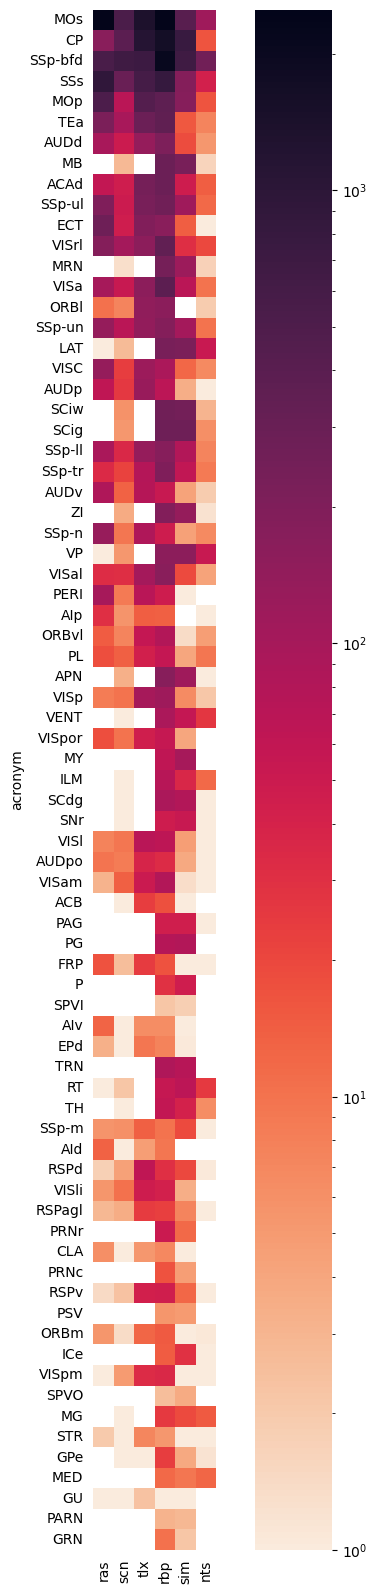

In [43]:
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(df_left, 
                norm=LogNorm(vmin= vmin, vmax= vmax),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\left_heatmap_avg_top75_logscale.svg')

#plt.show()

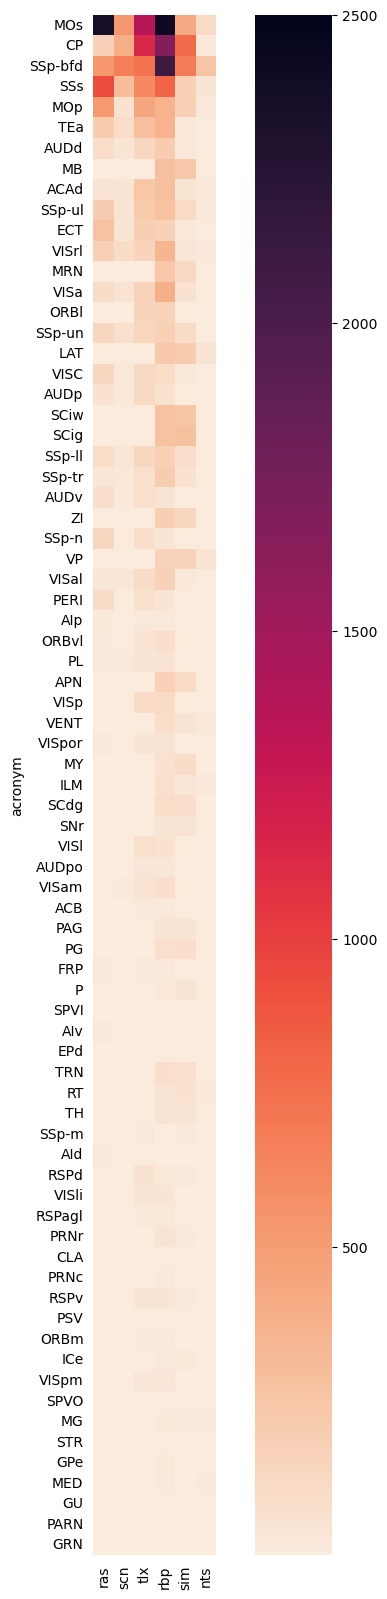

In [44]:
# linear scale
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(df_left, 
                cmap="rocket_r",
                square=True,
                vmin= vmin,
                vmax=vmax, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\left_heatmap_avg_top75_linearscale.svg')

#plt.show()

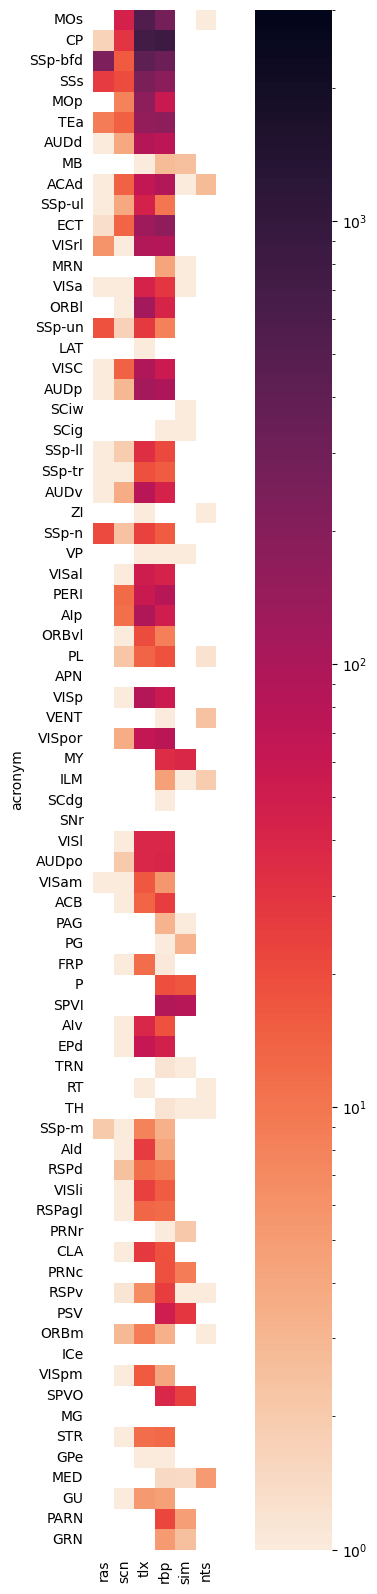

In [45]:
# repeat for right side
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(df_right, 
                norm=LogNorm(vmin=1, vmax= 3000),
                cmap="rocket_r",
                square=True,
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_avg_logscale.svg')

#plt.show()

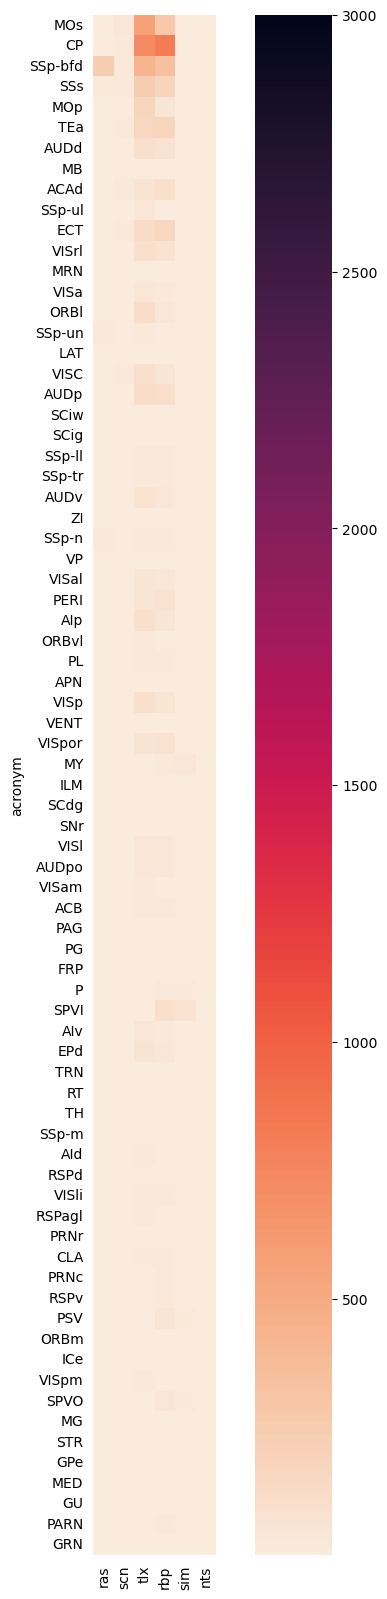

In [46]:
# linear scale, do not change vmin and vmax!! 1 and 3000
# repeat for right side
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(df_right, 
                cmap="rocket_r",
                square=True,
                vmin= 1,
                vmax=3000, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_avg_linearscale.svg')

#plt.show()

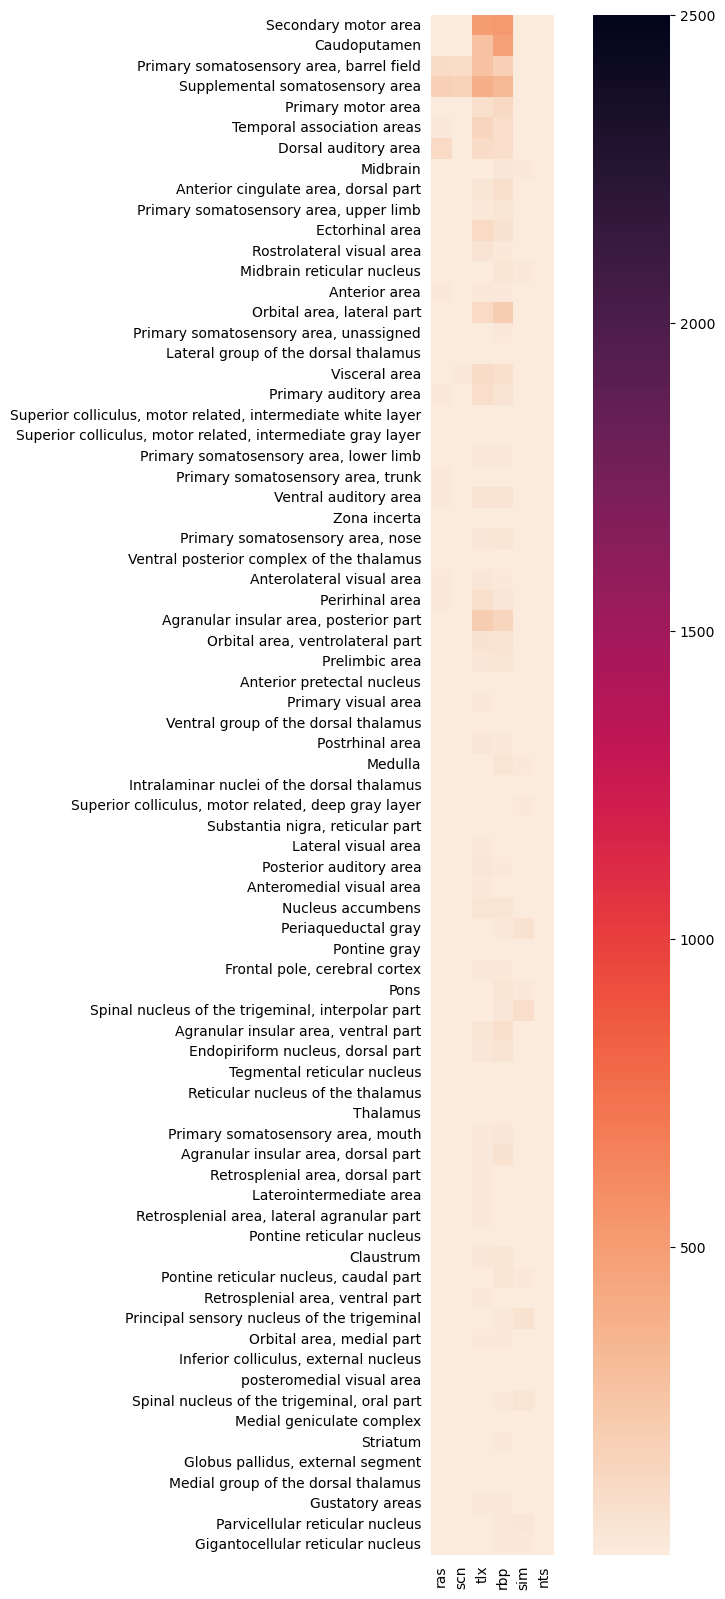

In [41]:
# generate a list of full name for the ordered acronyms

# This cell only need to be ran once for illustrator purposes-> get full labels instead of acronym

full_name=[]

for i in df_right.index:
    name=atlas_labels.query(f"acronym== '{i}'").name.values[0]
    full_name.append(name)

df_right_full = pd.DataFrame(df_right.values, index = full_name,
                  columns = df_right.columns)

# plot just one dataframe to get the row labels- then could just copy in illustrator

# linear scale, do not change vmin and vmax!! 1 and 6000
fig, ax = plt.subplots(figsize=(10,20))
g1= sns.heatmap(df_right_full,
                #right_50.drop(columns= 'Average'), 
                cmap="rocket_r",
                square=True,
                vmin= vmin,
                vmax= vmax, 
                linewidths=0.0,
                rasterized=True)

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{outdir}\\right_heatmap_avg_top75_linearscale_fullname.svg')

#plt.show()

### Figure 6

Correlation of categorical and spatial data

In [12]:
final_column_order=['AL254', 'AL257', 'AL255', 'AL303_s2', 'AL332_s2', 'AL333_s2', 'AL292', 'AL291', 'AL293', 'AL290', 'AL292_s2', 'AL290_s2', 'AL323_s2', 'AL313', 'AL213', 'AL314', 'AL280_s2', 'AL319_s2', 'AL278_s2', 'AL211', 'AL318', 'AL326_s2', 'AL288_s2', 'AL327_s2', 'AL207', 'AL273', 'AL209', 'AL321_s2', 'AL322_s2', 'AL281_s2', 'AL286_s2', 'AL285', 'AL274', 'AL311', 'AL330_s2', 'AL274_s2', 'AL310_s2']
# for ordering samples so that the samples are first organized in genotypes(ras, scn, tlx, rbp, sim, and nts. Then by their medial alteral injection site centroid)
# this list was obtained from this notebook under section for Figure 7--plot injection center ML vs. MO axon centroid AP and ML--

#### start with categorical data

In [3]:
# LOAD s1 excel fiels
indir= f'{working_directory}\s1_result'

column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL313','AL314','AL211','AL318', 'AL207','AL209','AL273','AL274','AL285','AL311']
# for verified s1 injections as of september .2023

In [4]:
axons_L= [ i for i  in os.listdir(indir) if 'left_region' in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)

axons_R= [ i for i  in os.listdir(indir) if 'right_region' in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

s1_df=pd.concat([axonal_df_L,axonal_df_R])
s1_df=s1_df[column_order]
#s1_df

In [5]:
indir= f'{working_directory}\s2_result'
#outdir = r'D:\test_dir\s2_result'

column_order= ['AL303','AL332','AL333','AL290','AL292','AL323', 'AL278', 'AL280', 'AL319', 'AL288', 'AL326', 'AL327', 'AL281', 'AL286', 'AL321', 'AL322', 'AL274', 'AL310', 'AL330']
#for s2 injections as of june.2023

In [6]:
axons_L= [ i for i  in os.listdir(indir) if 'left_region' in i]
axonal_df_L= combine_df(indir, axons_L)
axonal_df_L.fillna(0, inplace=True)

axons_R= [ i for i  in os.listdir(indir) if 'right_region' in i]
axonal_df_R= combine_df(indir, axons_R)
axonal_df_R.fillna(0, inplace=True)

right_acronym= [i+'_right' for i in axonal_df_R.index]
axonal_df_R['acronym']=right_acronym

axonal_df_R.set_index('acronym', inplace=True)
#Rename everything on the right side to preserve some spatial info

s2_df=pd.concat([axonal_df_L,axonal_df_R])
s2_df=s2_df[column_order]

s2_df.rename(lambda x: x+'_s2', axis='columns', inplace=True)
# rename sample names with a _s2 indicator since some samples have 2 channels (ie. AL274)

In [7]:
all_df=pd.concat([s1_df,s2_df])

final_df=all_df.groupby(level=0).sum()
# since after concat, each index will show up twice if it exist in both s1 and s2 dataframes where the first row have actual s1 value but have 0 for s2, and second row ahve actual s2 values but s1 have zeros.
# Sum up values of rows with identical name (anatomical region) by using group by sum

final_df=final_df[final_column_order]


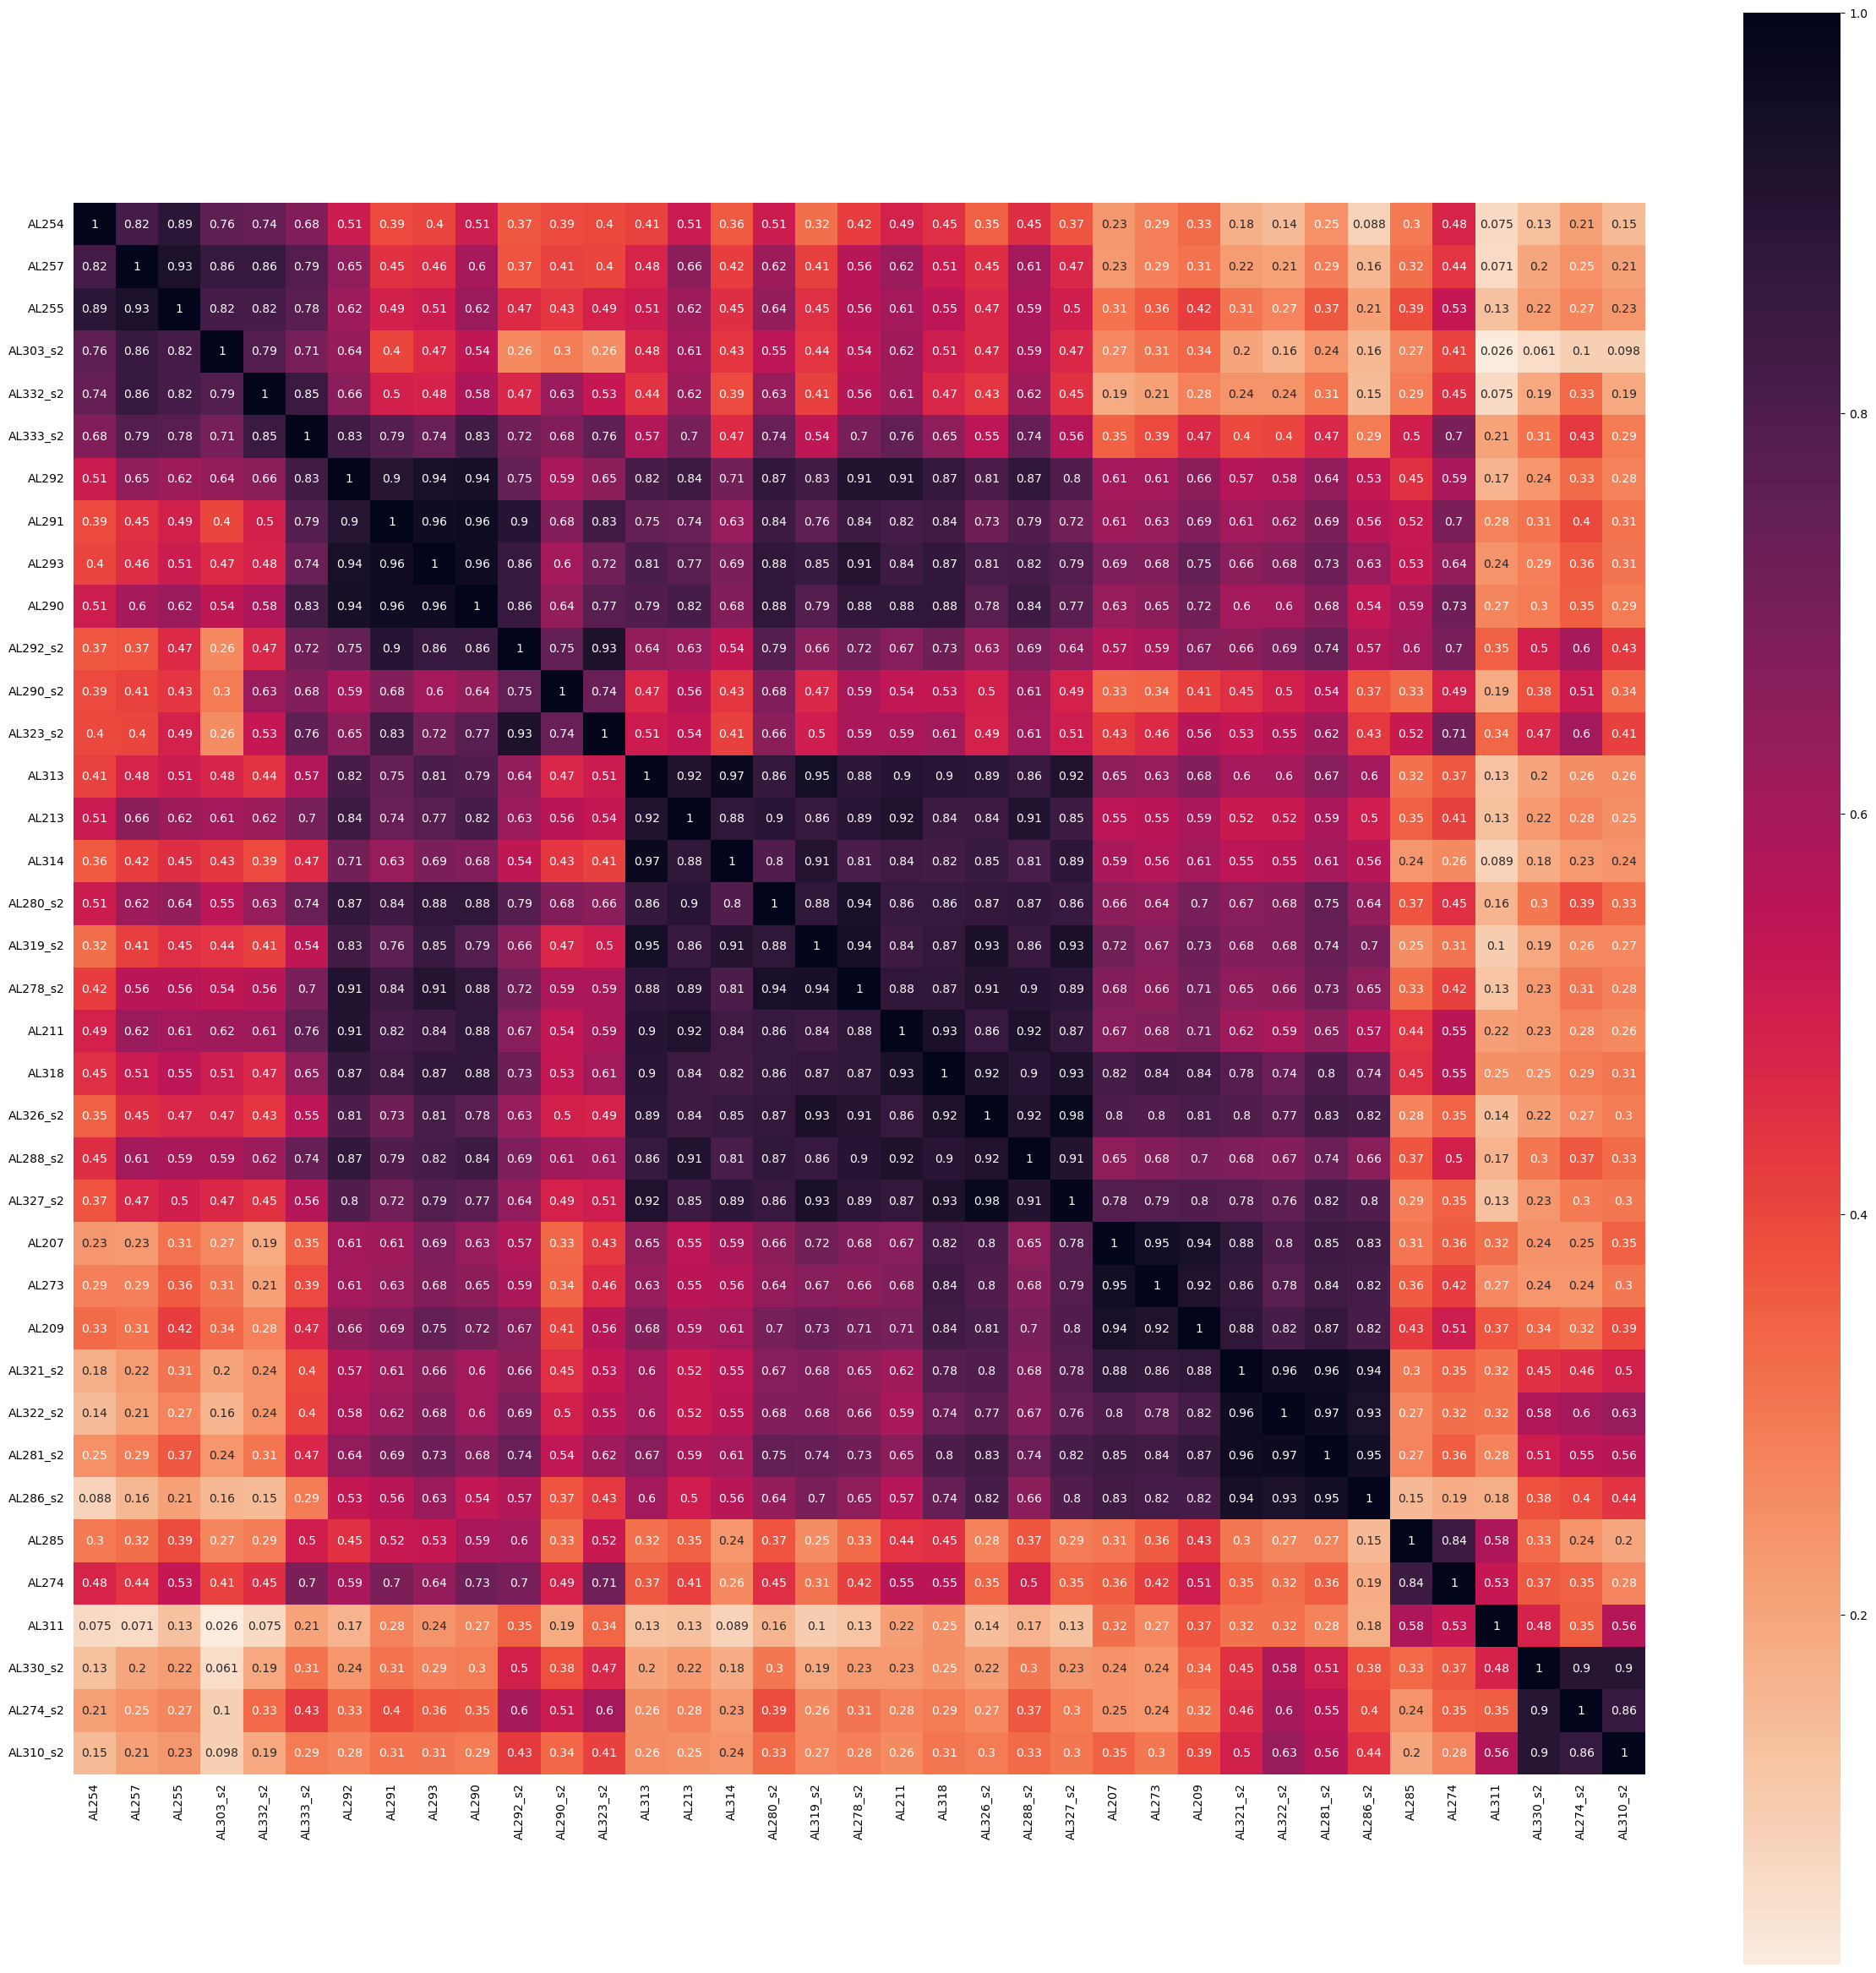

In [9]:
final_corr=final_df.corr()
final_corr.to_excel(f'{working_directory}\s1_s2\Data_Categorical_correlation.xlsx')

fig, ax = plt.subplots(figsize=(30,30))
g1=sns.heatmap(final_corr,  cmap="rocket_r", annot=True, square=True,linewidths=0.0, rasterized=True)
# set line width=0 and rasterized= true because when importing svg in illustrator, random whitelines are showing!

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(f'{working_directory}\s1_s2\\all_correlation.svg')
#plt.show()

#### Next, move on to spatial data

In [11]:
from scipy.ndimage import gaussian_filter

In [13]:
# paths for s1 samples
site='s1'

indir= f'{working_directory}\\{site}\\npy'

files= os.listdir(indir)

# paths for s2 samples
site='s2'

indir2= f'{working_directory}\\{site}\\npy'

files2= os.listdir(indir2)

In [14]:
# load the atlas (npy)

atlas= axons=np.load(f'{working_directory}\ARA_25_micron_mhd_ccf2017\\annotation_25.npy')


atlas_h=np.moveaxis(atlas, 1, 0)
print('Converted to horizontal atlas with shape', atlas_h.shape)
# reslice corontal atlas to horizontal atlas that is consistent with our sample's orientation


atlas_flat= atlas_h.flatten()
atlas_flat_mask = np.argwhere(atlas_flat>1)
# flatten annotation as an 1d array
# find indices of this 1d array that is not zero

Converted to horizontal atlas with shape (320, 528, 456)


In [15]:
# initialize bunch of things

n_files= len(files)+len(files2)

axons_array= np.empty([len(atlas_flat_mask), n_files])
# create empty array of shape ( 32380454, # of samples from both s1 and s2) to store the gaussian filtered, masked and flatted axons 

sample_name=[]
# initialize list to store sample name

In [19]:
# this should take ~ 10 minutes

sigma=4
# sigma for gaussian filter
# radius is truncate(default,4) * sigma, hence a sigma=4 has a radius of 16 pixel which is 400 um
# keep this consistent as sigma=4 is used for quantifying MO axon centroids!!

# 4 is appearantly not giving enough similarities for tsne or umap to give sensible projections

for count, i in enumerate(files): 
    
    file_path=os.path.join(indir,i)
    this_sample= find_mousename(i)
    # find the sample name
    
    sample_name.append(this_sample)
    
    axons=np.load(file_path)
    axons[0,0,0]=0
    axons[1,0,0]=0
    # load npy file and revert these two indices back to 0
    
    axons_filtered=gaussian_filter(axons, sigma=sigma)
    # apply 3d gaussian filter to axon
    
    axons_flat= axons_filtered.flatten()
    axons_flat_masked= axons_flat[atlas_flat_mask]
    # only take axons at indices that was non-zero in the atlas
    
    axons_array[:, count]= axons_flat_masked.T
    # transpose flatted axons and assign into numpy array

# repeat for s2 samples
for count, i in enumerate(files2): 
    
    file_path=os.path.join(indir2,i)
    this_sample= find_mousename(i)
    # find the sample name
    
    sample_name.append(this_sample+'_s2')
    # add an _s2 indicator, for later ordering of samples
    
    axons=np.load(file_path)
    axons[0,0,0]=0
    axons[1,0,0]=0
    # load npy file and revert these two indices back to 0
    
    axons_filtered=gaussian_filter(axons, sigma=sigma)
    # apply 3d gaussian filter to axon
    
    axons_flat= axons_filtered.flatten()
    axons_flat_masked= axons_flat[atlas_flat_mask]
    # only take axons at indices that was non-zero in the atlas
    
    axons_array[:, len(files)+count]= axons_flat_masked.T
    # transpose flatted axons and assign into numpy array after the s1 samples
    
# each column= 1 sample, each row= 1 axon in each position


In [26]:
# Correlation

b = np.corrcoef(axons_array.T)
# calculate correlation between each sample
correlation_3d=pd.DataFrame(data=b, index=sample_name, columns=sample_name)

# rearrange columns and rows according to order
test=correlation_3d[final_column_order] 
test=test.T
ordered_corr=test[final_column_order]

ordered_corr.to_excel(f'{working_directory}\\s1_s2\\correlation_3d_sigma{sigma}.xlsx')
# save as xlsx files to be plotted later

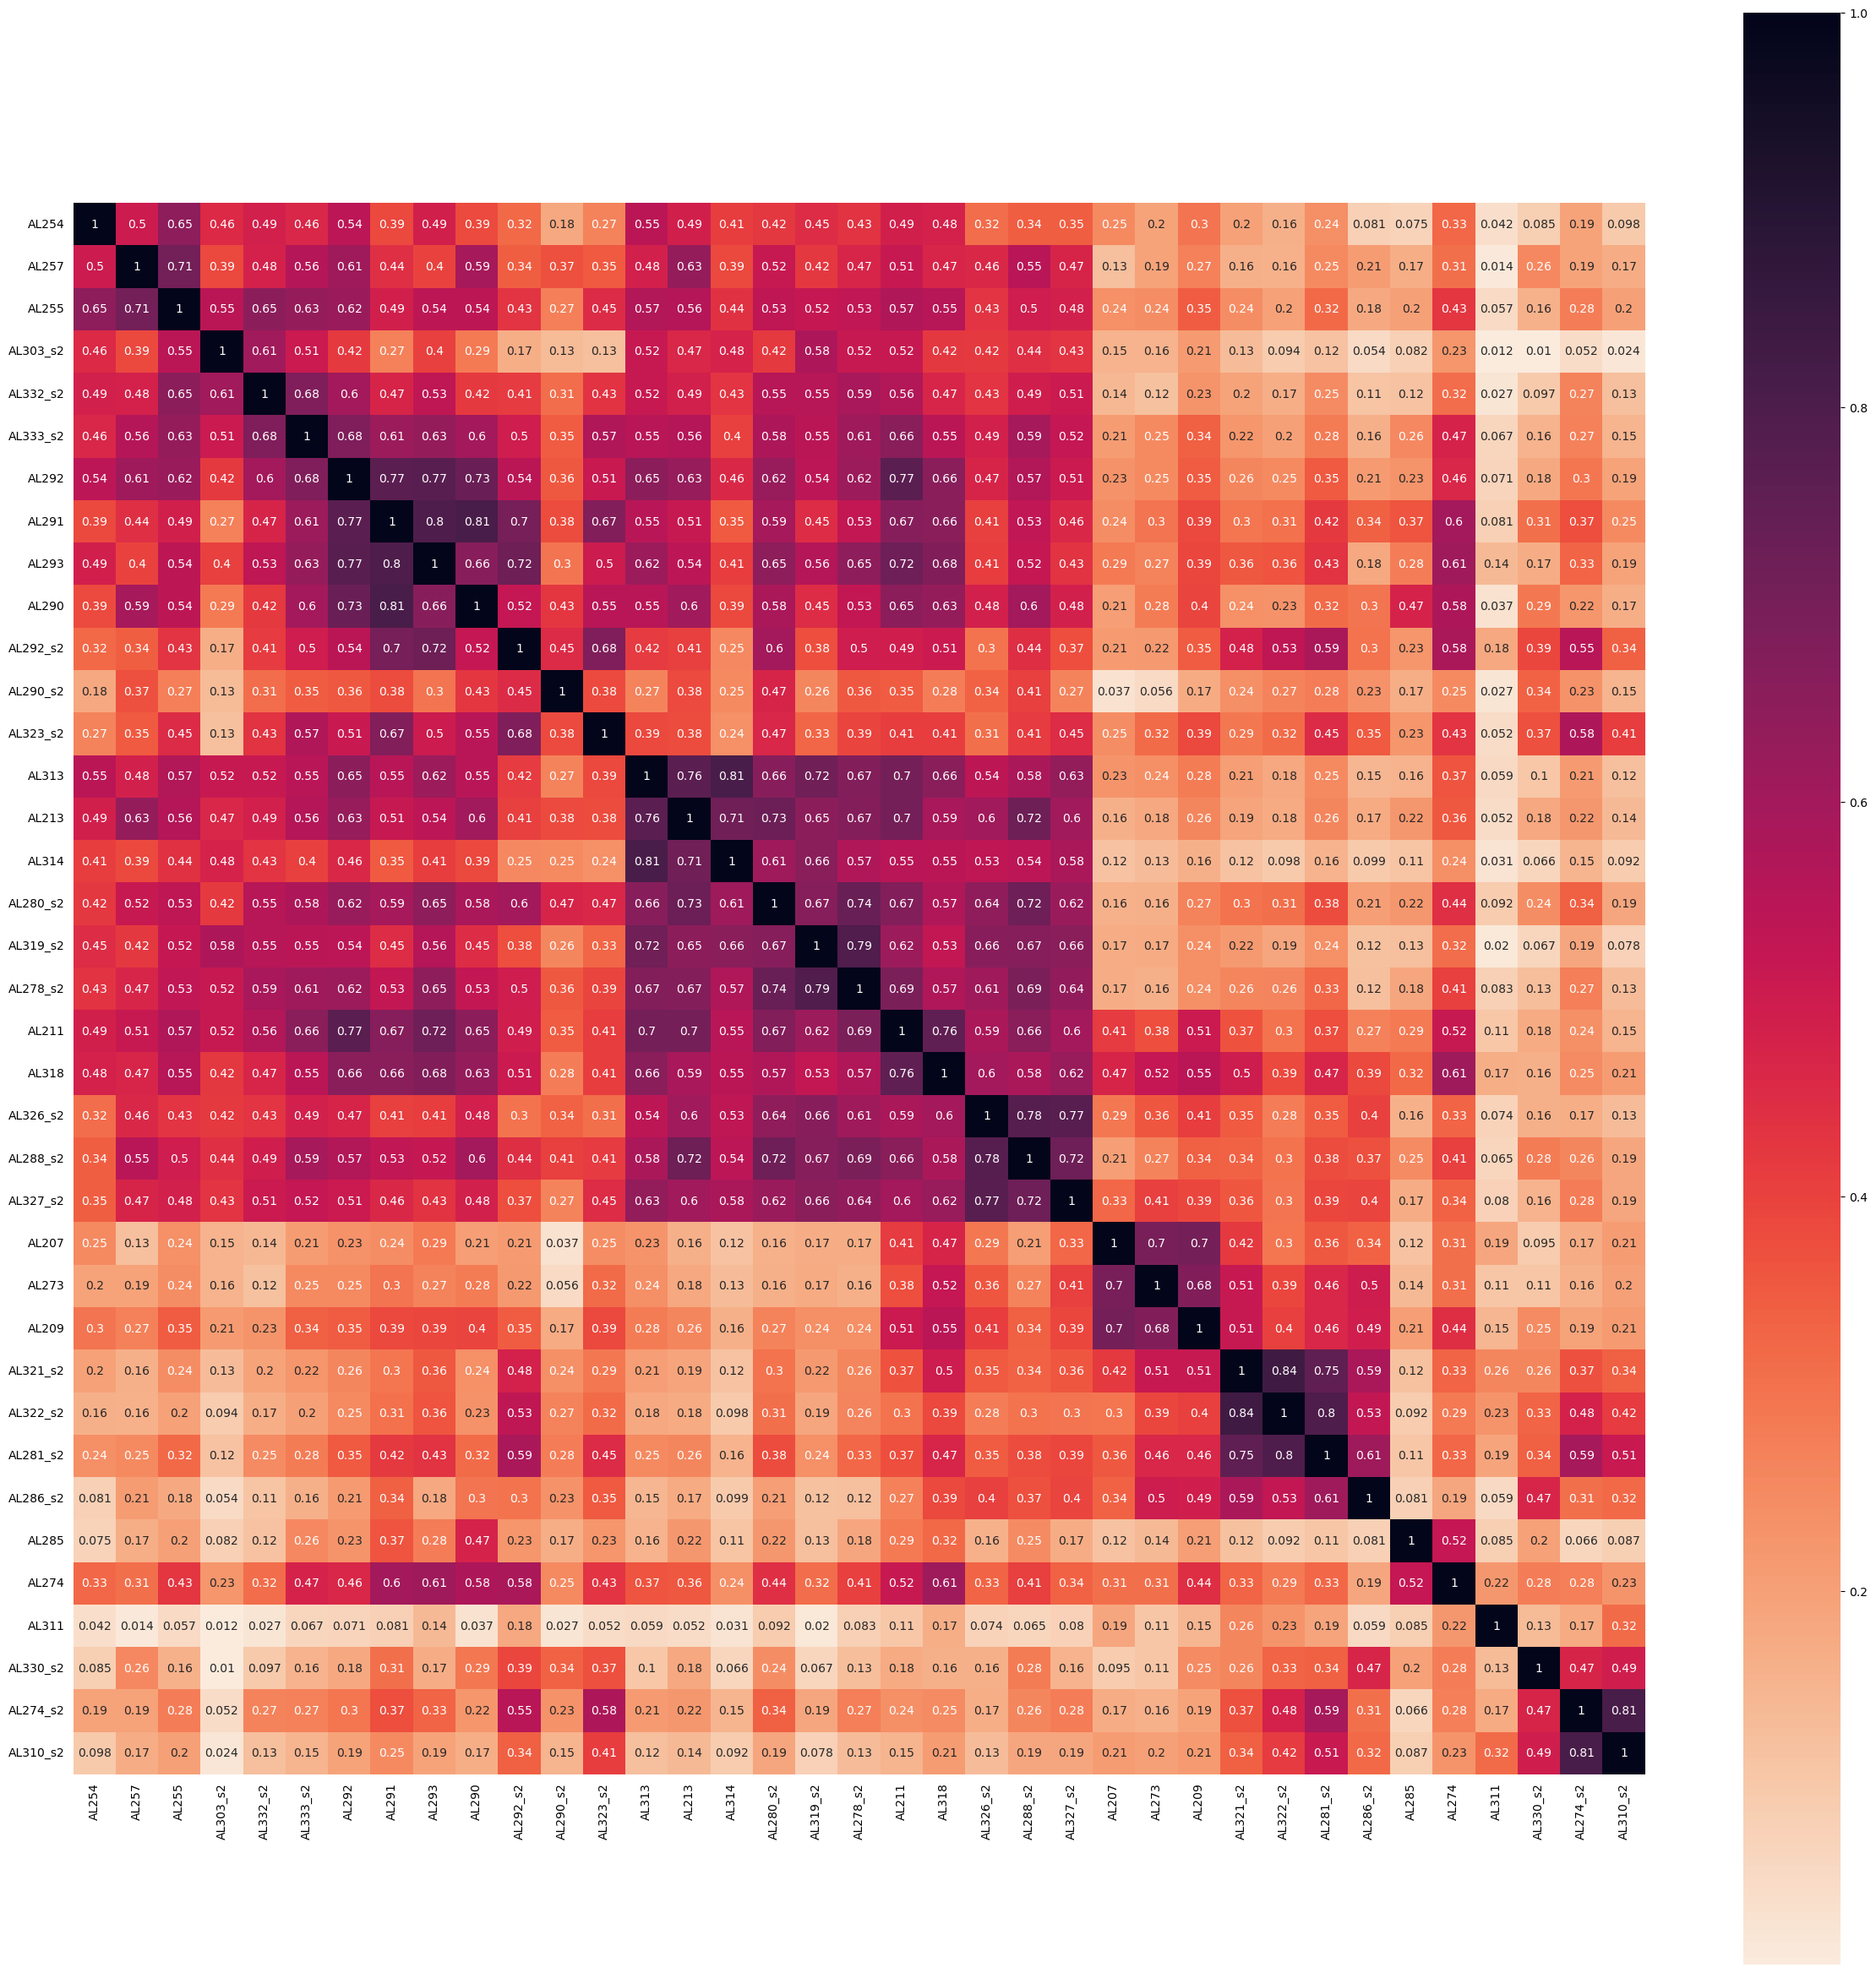

In [32]:
#plot
fig, ax = plt.subplots(figsize=(30,30))
g1=sns.heatmap(ordered_corr,  cmap="rocket_r", annot=True, square=True,linewidths=0.0, rasterized=True)
# set line width=0 and rasterized= true because when importing svg in illustrator, random whitelines are showing!

g1.tick_params(bottom=False, left=False)
# disable ticks because it is such a mess in illustrator!

plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(r'{working_directory}\s1_s2\\all_spatial_sigma4.svg')
plt.show()

### Figure 7

In [5]:
def conv_stereo(ML, AP, realum):
    '''input data points in terms of pixels and real pixel size in micrometers 
    calculates stereotaxic coordinate and return as ML, AP values'''
    bregma= [227.5, 215]
    # bregma coordiantes in horizontal view, where image dimension is [456, 528]
        
    tmpmedlat= abs(bregma[0]-ML)
    tmpantpos=bregma[1]- AP
    
    factor= realum/1000
    medlat=tmpmedlat*factor
    antpos= tmpantpos*factor
    # convert pixels to real micrometers
    
    return round(medlat,2), round(antpos,2)

In [19]:
s1_data=pd.read_csv (f'{working_directory}\ML_centroids\s1_s1.csv')
s2_data=pd.read_csv (f'{working_directory}\ML_centroids\s2_s2.csv')

inj_center= pd.read_excel(f'{working_directory}\results_expanded.xlsx')

outdir= f'{working_directory}\ML_centroids\\'

In [8]:
s1_data['site']= 's1'
s2_data['site']= 's2'

MO_center= pd.concat([s1_data, s2_data])


In [9]:
inj_center=inj_center[inj_center['over_eighty']==True]
# pick out qualified samples

site=[]
for i in inj_center.Centroid_id_name:
    if 'SSs' in i:
        site.append('s2')
    elif 'SSp' in i:
        site.append('s1')

        
inj_center['site']=site

# add a column specifying injection site, for later merging with MO axon centroids (need both sample name and site to identify, especially for cases where s1 and s2 injections are made in the same brain)

In [10]:
sample_list=[]
for i in inj_center.Data_name:
    sample_list.append(find_mousename(i))
        
inj_center['sample']=sample_list

# add a column specifying sample name in ALXXX format, for later merging with MO axon centroids (need both sample name and site to identify, especially for cases where s1 and s2 injections are made in the same brain)

genotypes= inj_center.Genotype.unique()
# get list of genotype

In [13]:
inj_ML=[]
inj_AP=[]
for i in range(0, len(inj_center)):
    
    this_sample= inj_center.iloc[i]
    
    ML, AP= conv_stereo(this_sample['Centroid_location_1'],this_sample['Centroid_location_2'],25)
    inj_ML.append(ML)
    inj_AP.append(AP)

inj_center['inj_ML']= inj_ML
inj_center['inj_AP']= inj_AP

In [14]:
test_df = pd.merge(inj_center, MO_center, on=['sample','site'])

#test_df.sort_values(by= ['site'], inplace=True)

test_df_real= test_df[test_df.axons_95>0]
# remove samples with no MO axons at all

test_df_real.sort_values(by=['site'], inplace=True)
# sort by s1 or s2 injection site

In [15]:
# GENERATE sample order -> genotype first, then by injection site medial lateral positions

order=['Rasgrf2dCre', 'Scnn1aCre', 'Tlx3Cre', 'Rbp4Cre', 'Sim1Cre', 'Ntsr1Cre']

# define order of genotype

test_df['Genotype'] = pd.Categorical(test_df['Genotype'], ordered=True, categories=order)
df = test_df.sort_values('Genotype')
# use pd.categorical so we can arrange genotype in this order

df.sort_values(by=['Genotype', 'inj_ML'], inplace=True)
df.head()

,Unnamed: 0_x,Data_name,Total_voxels,Centroid_location_1,Centroid_location_2,Centroid_location_3,Centroid_id,Voxel_id,Genotype,Centroid_id_name,...,over_eighty,site,sample,inj_ML,inj_AP,Unnamed: 0_y,ML,AP,area_75,axons_95
6,10,AL254_561,4580,97,281,46,201,"[{201: 2937, 981: 1217, 1047: 426}]",Rasgrf2dCre,SSp-bfd2/3,...,True,s1,AL254,3.26,-1.65,4,0.81,0.68,147,12.426752
11,19,AL257_561,4327,79,263,60,981,"[{201: 2459, 981: 1868}]",Rasgrf2dCre,SSp-bfd1,...,True,s1,AL257,3.71,-1.20,6,1.09,1.10,676,140.794258
7,11,AL255_561,9959,76,284,61,201,"[{201: 6655, 806: 771, 873: 187, 981: 2043, 10...",Rasgrf2dCre,SSp-bfd2/3,...,True,s1,AL255,3.79,-1.72,5,0.89,1.20,178,23.469630
8,15,AL303_561,3288,62,294,73,806,"[{201: 2, 527: 1, 600: 1, 806: 2222, 873: 804,...",Rasgrf2dCre,SSs2/3,...,True,s2,AL303,4.14,-1.98,8,0.71,1.33,240,8.232679
10,18,AL332_561,1143,54,287,77,873,"[{0: 52, 527: 17, 806: 293, 873: 781}]",Rasgrf2dCre,SSs1,...,True,s2,AL332,4.34,-1.80,17,0.66,1.18,251,45.507645


In [16]:
sorted_sample_ML= []
for i in range(0, len(df)):
    this_row= df.iloc[i]
    
    if this_row.site =='s2':
        sorted_sample_ML.append(this_row['sample'] +'_s2')
    else :
        sorted_sample_ML.append(this_row['sample'])

print(sorted_sample_ML)

print('This becomes the ordering of samples used in correlation maps')

['AL254', 'AL257', 'AL255', 'AL303_s2', 'AL332_s2', 'AL333_s2', 'AL292', 'AL291', 'AL293', 'AL290', 'AL292_s2', 'AL290_s2', 'AL323_s2', 'AL313', 'AL213', 'AL314', 'AL280_s2', 'AL319_s2', 'AL278_s2', 'AL211', 'AL318', 'AL326_s2', 'AL288_s2', 'AL327_s2', 'AL207', 'AL273', 'AL209', 'AL321_s2', 'AL322_s2', 'AL281_s2', 'AL286_s2', 'AL285', 'AL274', 'AL311', 'AL330_s2', 'AL274_s2', 'AL310_s2']
This becomes the ordering of samples used in correlation maps


plot correlation between injection site ML and MO axon AP

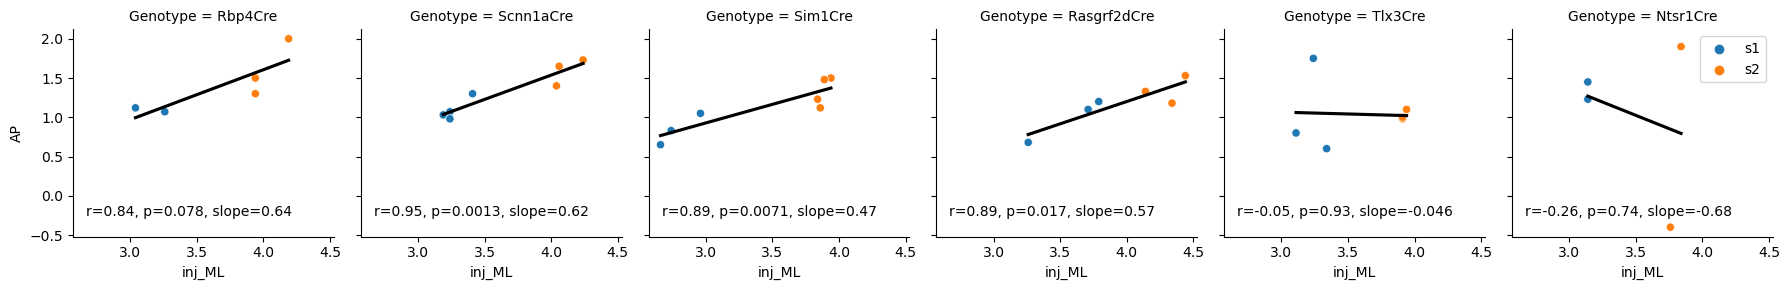

In [20]:
import scipy 

def annotate(data, **kws):
    #r, p = scipy.stats.pearsonr(data['inj_ML'], data['AP'])
    slope, _, r, p, _ = scipy.stats.linregress(data['inj_ML'], data['AP'])
    ax = plt.gca()
    ax.text(.05, .1, 'r={:.2f}, p={:.2g}, slope={:.2g}'.format(r, p, slope),
            transform=ax.transAxes)


g = sns.FacetGrid(test_df_real, col="Genotype")
# create a facet grid

g.map_dataframe(sns.regplot, x='inj_ML', y='AP', data=test_df_real, ci=None, scatter=False, color='k')
# map regression line to facet grid but hide scatter, because we calculate it based on all data from the same cre line 
# but still want to indicate s1 vs s2 injection some how and regplot doesnt take color argument (it will plot two separate regression lines!)

g.map_dataframe(sns.scatterplot, x='inj_ML', y='AP', hue='site',  data=test_df_real)
# map scatter plots onto facet grid to use color to indicate injection site information

g.map_dataframe(annotate)
# write r value and p values for the regression line

plt.legend()
plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!

plt.savefig(outdir+ "inj_ML_vs_MO_AP.svg")

plt.show()

In [21]:
to_save=df[['sample', 'site', 'Genotype','inj_ML', 'inj_AP', 'ML', 'AP', 'area_75', 'axons_95' ]].copy()

to_save.to_excel(outdir+'Data_MO_innervation.xlsx')

# save the data for publication purpose

Plot dots indicating center locations and corresponding connections

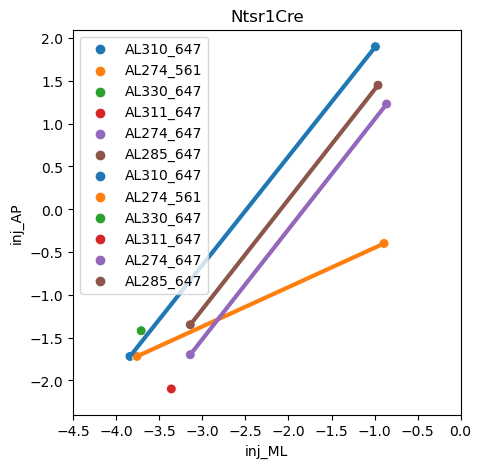

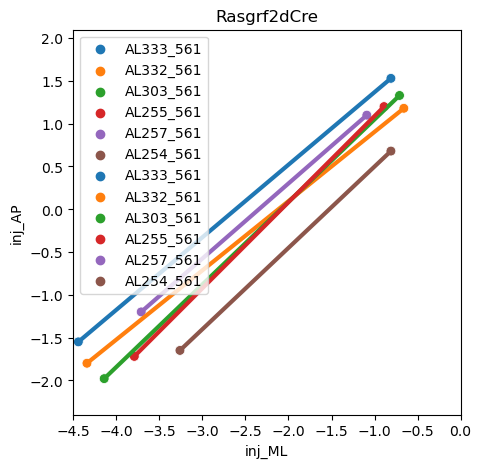

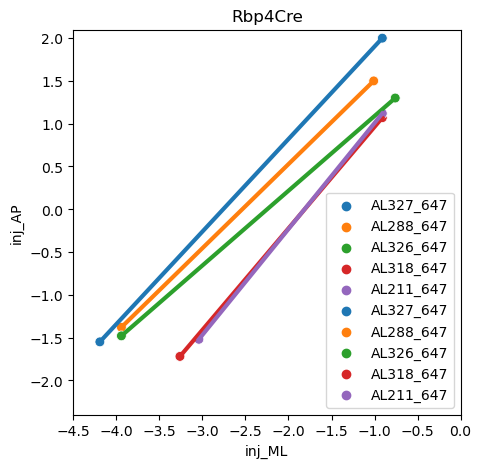

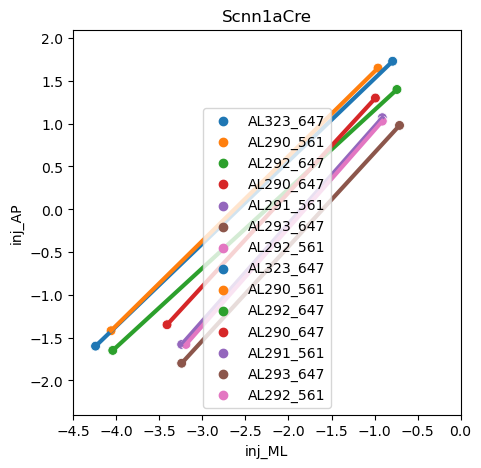

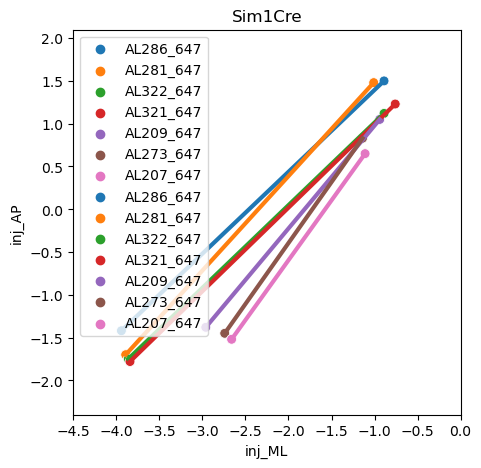

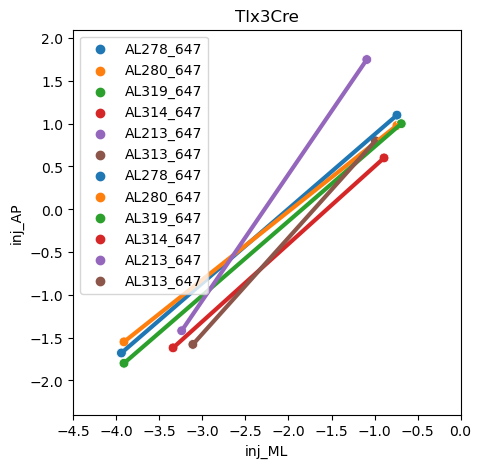

In [23]:
for i in genotypes:
    this_df= test_df[test_df.Genotype==i]
    #this_df = pd.merge(this_genotype, MO_center, on=['sample','site'])
    
    this_df['inj_ML']= this_df['inj_ML'] *-1
    this_df['ML']= this_df['ML'] *-1
    # take a negative sign on injection center ML and MO center ML so it appears on the left side
    
    
    this_df.sort_values(by=['inj_ML'], ascending=True, inplace=True)
    #sort by injection center medial lateral so that the first color is always the most lateral one
    
    
    f, ax = plt.subplots(figsize=(5, 5))
    sns.scatterplot(x="inj_ML", y="inj_AP",
                    data=this_df, ax=ax,
                   hue= "Data_name", marker="o",
                   s = 50)
    
    sns.scatterplot(x="ML", y="AP",
                    data=this_df, ax=ax,
                   hue= "Data_name", marker="o",
                   s=50 )
    
    
    # to plot lines connecting the injection site center and MO region center
    x=[]
    y=[]
    # initialize list

    for j in range(0,len(this_df)):
        this_row= this_df.iloc[j]
        x.append(this_row.inj_ML)
        x.append(this_row.ML)

        y.append(this_row.inj_AP)
        y.append(this_row.AP)

        sns.lineplot(x=x,y=y, ax=ax, linewidth=3)

        x=[]
        y=[]
        # reinitialize list


    ax = plt.gca()
    ax.set_title(i)
    
    ax.set_xlim(-4.5, 0)
    ax.set_ylim(-2.4, 2.1)
    # set x and y limit so all graphs are in the same x and y axis
    
    plt.rcParams['svg.fonttype'] = 'none'
    # so text stay as text not paths!
    
    plt.savefig(f"{outdir}inj_MO_centroid_{i}.svg")

Quantify area of 75% contour and axon counts within 95% contour

In [24]:
## quantify area of 75% contour and axon numbers within the 95% contour

order=['Rasgrf2dCre', 'Scnn1aCre', 'Tlx3Cre', 'Rbp4Cre', 'Sim1Cre', 'Ntsr1Cre']

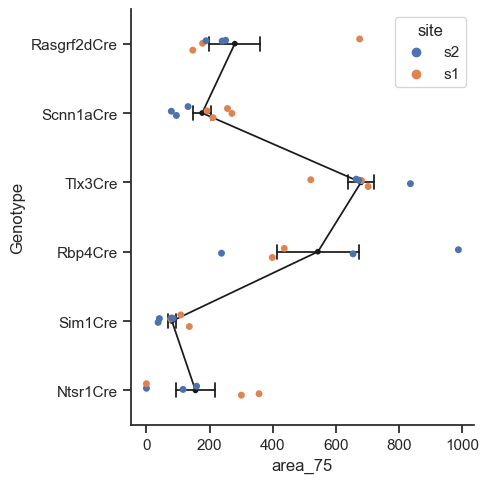

In [25]:
sns.set(style="ticks", rc={"lines.linewidth": 0.7})

sns.catplot(
    data=test_df, x="area_75", y="Genotype", errorbar="se",
    capsize=.2, kind='point', color= 'k', order=order)


sns.stripplot(data=test_df, x="area_75", y="Genotype", hue="site", order=order)
plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!
plt.savefig(outdir+"area_75.svg")

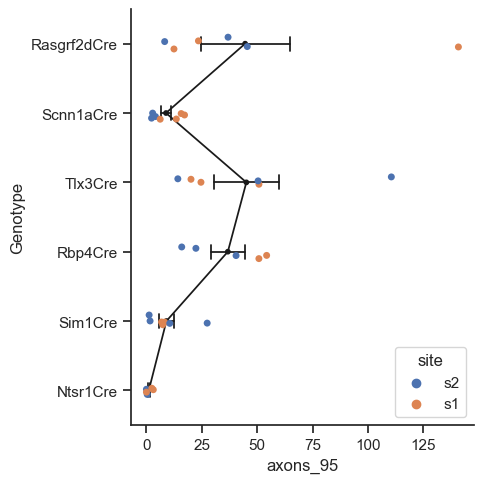

In [26]:
sns.set(style="ticks", rc={"lines.linewidth": 0.7})

sns.catplot(
    data=test_df, x="axons_95", y="Genotype", errorbar="se",
    capsize=.2, kind='point', color= 'k', order=order)


sns.stripplot(data=test_df, x="axons_95", y="Genotype", hue="site", order=order)
plt.rcParams['svg.fonttype'] = 'none'
# so text stay as text not paths!
plt.savefig(outdir+"axons_95.svg")